In [1]:
from csromer.simulation import FaradayThinSource,FaradayThickSource
from csromer.reconstruction import Parameter
import numpy as np
from IPython.display import clear_output
from csromer.io import Reader, Writer
from csromer.base import Dataset
from csromer.transformers import DFT1D, NUFFT1D
import matplotlib.pyplot as plt
from csromer.objectivefunction import OFunction
from csromer.utils import real_to_complex, complex_to_real
from csromer.objectivefunction import TSV, TV, L1, Chi2
from csromer.optimization import FISTA, ADMM, SDMM, GradientBasedMethod
from csromer.utils import Gaussian
from csromer.dictionaries.discrete import DiscreteWavelet
from csromer.dictionaries.undecimated import UndecimatedWavelet
from csromer.transformers import Gridding
from scipy.constants import c
from pynufft import NUFFT
from scipy import signal as sci_signal
import itertools

In [2]:
def chi2_calc(residuals):
    if residuals.dtype == np.complex64 or residuals.dtype == np.complex128:
        data = (residuals.real * residuals.real) + (residuals.imag * residuals.imag)
    else:
        data = residuals**2
    return np.sum(data)

In [3]:
def aicbic(residuals_coeffs, x_coeffs):
    rss = chi2_calc(residuals)
    if x.dtype == np.complex64 or x.dtype == np.complex128:
        df = np.count_nonzero(x.real) + np.count_nonzero(x.imag)
    else:     
        df = np.count_nonzero(x)
    l = len(residuals)
    return l*np.log(rss/l) + 2*df, l*np.log(rss/l) + df*np.log(l)

In [4]:
np.random.seed(666)

In [5]:
# JVLA 1.008e9 - 2.031e9 1000
nu = np.linspace(start=1.008e9, stop=2.031e9, num=1000)

In [6]:
peak_thinsource = 0.004
peak_thicksource = 0.004

In [7]:
thinsource1 = FaradayThinSource(nu=nu, s_nu=peak_thinsource, phi_gal=124, spectral_idx=1.0)
thinsource2 = FaradayThinSource(nu=nu, s_nu=peak_thinsource/2, phi_gal=50, spectral_idx=-0.5)
thinsource3 = FaradayThinSource(nu=nu, s_nu=peak_thinsource/2, phi_gal=200, spectral_idx=-0.5)

In [8]:
thinsource1.simulate()
thinsource2.simulate()
thinsource3.simulate()

In [9]:
thinsource = thinsource1 #+ thinsource2 + thinsource3

In [10]:
#140 JVLA
# 95 MeerKAT
thicksource = FaradayThickSource(nu=nu, s_nu=peak_thicksource, phi_fg=90, phi_center=200, spectral_idx=1.0)

In [11]:
#thinsource.simulate()
thicksource.simulate()

In [12]:
measurements = thinsource

In [13]:
#measurements.remove_channels(0.33, chunksize=100)

In [14]:
measurements.apply_noise(peak_thinsource*0.5)

In [15]:
len(measurements.lambda2)

1000

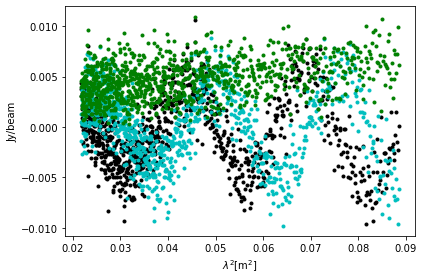

In [16]:
plt.plot(measurements.lambda2, measurements.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
#plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('polarized.png', dpi=100, bbox_inches='tight')

In [17]:
#measurements.apply_noise(peak_thinsource*0.1)

In [18]:
#measurements.remove_channels(0.33, chunksize=100)

In [19]:
len(measurements.lambda2)

1000

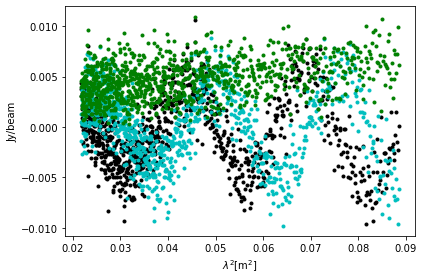

In [20]:
plt.plot(measurements.lambda2, measurements.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
#plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('polarized.png', dpi=100, bbox_inches='tight')

In [21]:
parameter = Parameter()

In [22]:
parameter.calculate_cellsize(dataset=measurements)

FWHM of the main peak of the RMTF: 51.962 rad/m^2
Maximum recovered width structure: 144.188 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 25954.896


In [23]:
nufft = NUFFT1D(dataset=measurements, parameter=parameter, solve=True)

In [24]:
dft = DFT1D(dataset=measurements, parameter=parameter)

In [25]:
F_dirty = dft.backward(measurements.data)

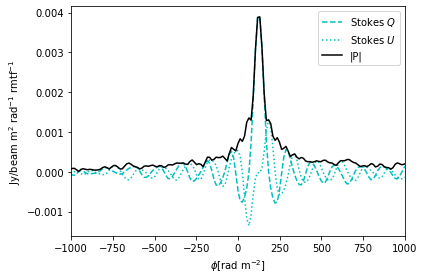

In [26]:
plt.plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_dirty), 'k-', label=r"|P|")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000,1000])
plt.tight_layout()
#plt.savefig('fdirty.png', dpi=100, bbox_inches='tight')

In [27]:
idx_noise = np.where(np.abs(parameter.phi)>parameter.max_faraday_depth/2)
noise_F = 0.5 * (np.std(F_dirty[idx_noise].real) + np.std(F_dirty[idx_noise].imag))
noise_F

7.520095095969737e-05

In [28]:
P_back = nufft.forward_normalized(F_dirty)

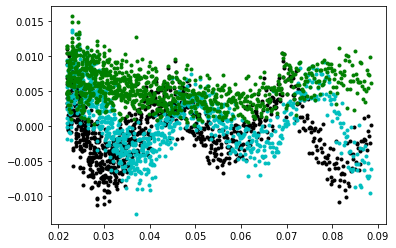

In [29]:
plt.plot(measurements.lambda2, P_back.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, P_back.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(P_back), 'g.', label=r"$|P|$")

In [30]:
F_back = nufft.backward(measurements.data)

(-1000.0, 1000.0)

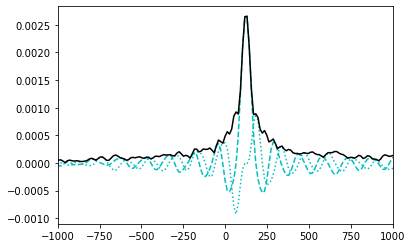

In [31]:
plt.plot(parameter.phi, F_back.real, 'c--', label=r"Real part")
plt.plot(parameter.phi, F_back.imag, 'c:', label=r"Imaginary part")
plt.plot(parameter.phi, np.abs(F_back), 'k-', label=r"Amplitude")
plt.xlim([-1000,1000])

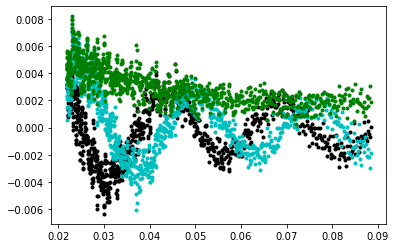

In [32]:
P_back = nufft.forward_normalized(F_back)
plt.plot(measurements.lambda2, P_back.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, P_back.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(P_back), 'g.', label=r"$|P|$")

In [33]:
#wav = DiscreteWavelet(wavelet_name="rbio5.5", mode="periodization")
wav = UndecimatedWavelet(wavelet_name="coif2")

In [34]:
lambda_l1 = np.sqrt(2 * measurements.m + np.sqrt(4 * measurements.m)) * noise_F
#lambda_l1 = np.sqrt(len(measurements.data)) * noise_F
#lambda_l1 /= 5
#lambda_l1=0.5
lambda_tsv = 0.0
chi2 = Chi2(dft_obj=nufft, wavelet=wav)
l1 = L1(reg=lambda_l1)
tsv = TSV(reg=lambda_tsv)
# F_func = [chi2(P, dft, W), L1(lambda_l1)]
F_func = [chi2, l1, tsv]
f_func = [chi2]
g_func = [l1, tsv]

F_obj = OFunction(F_func)
f_obj = OFunction(f_func)
g_obj = OFunction(g_func)

In [35]:
len(F_back)

3968

In [36]:
len(parameter.data)

3968

In [37]:
parameter.data = F_dirty

In [38]:
parameter.complex_data_to_real()

In [39]:
wav.calculate_max_level(parameter.data)

8

In [40]:
parameter.data = wav.decompose(parameter.data)

In [41]:
parameter.n

71424

In [42]:
nufft.parameter.n

3968

In [44]:
opt = FISTA(guess_param=parameter, F_obj=F_obj, fx=chi2, gx=g_obj, noise=noise_F, verbose=True)
#opt = FISTA(i_guess=F_real, F_obj=F_obj, fx=chi2, gx=g_obj, maxiter=1000, noise=1e-5, verbose=True)
obj, X = opt.run()

Iterations set to 45
Iteration:  0  objective function value: 0.01242


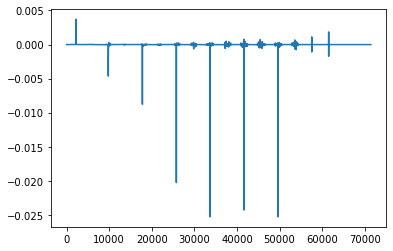

In [45]:
# Coefficients
plt.plot(X.data)

In [46]:
print(X.calculate_sparsity()) # 99.9977453102453 542
print(np.count_nonzero(X.data)) # wavelet 99.98422464111059 42

99.99859991039428
6016


In [47]:
X.data = wav.reconstruct(X.data)

(-1000.0, 1000.0)

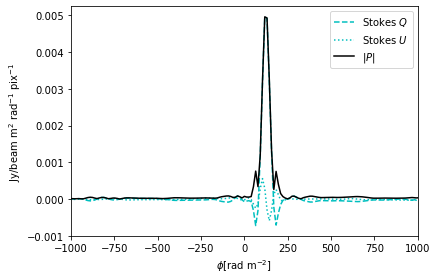

In [48]:
X.real_data_to_complex()

plt.plot(parameter.phi, X.data.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, X.data.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(X.data), 'k-', label=r"$|P|$")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim([-1000,1000])

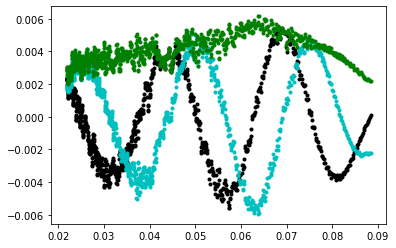

In [49]:
plt.plot(measurements.lambda2, measurements.model_data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.model_data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.model_data), 'g.', label=r"$|P|$")
#plt.ylim([-0.007,0.008])

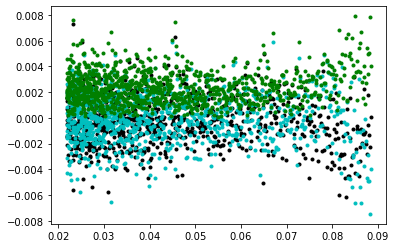

In [50]:
plt.plot(measurements.lambda2, measurements.residual.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.residual.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.residual), 'g.', label=r"$|P|$")

(-1000.0, 1000.0)

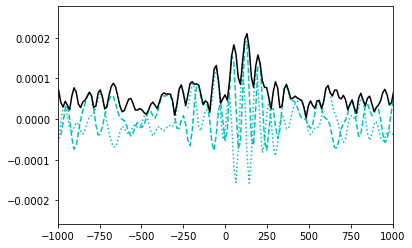

In [51]:
F_residual = dft.backward(measurements.residual)
plt.plot(parameter.phi, F_residual.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_residual.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_residual), 'k-', label=r"$|P|$")
plt.xlim([-1000,1000])

In [52]:
0.5 * (np.std(F_residual.real) + np.std(F_residual.imag))

5.614952897303738e-05

In [53]:
model_2 = dft.backward(measurements.model_data)

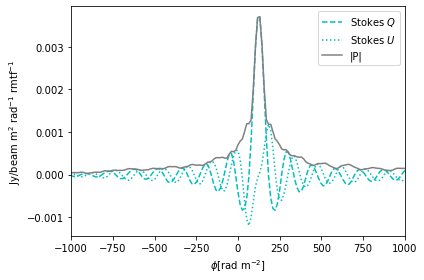

In [54]:
plt.plot(parameter.phi, model_2.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, model_2.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(model_2), '-', c='grey', label=r"|P|")
#plt.plot([-200.,-200.],[0.,0.0035],ls='-',lw=2.,c='black')
#plt.plot(parameter.phi,np.zeros(len(parameter.phi)),ls='-',lw=2.,c='black')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000,1000])
plt.tight_layout()
#plt.savefig("fds_sim1.png", dpi=100)

In [55]:
residual_faraday = F_dirty - model_2

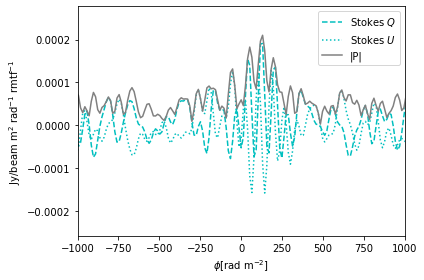

In [56]:
plt.plot(parameter.phi, residual_faraday.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, residual_faraday.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(residual_faraday), '-', c='grey', label=r"|P|")
#plt.plot([-200.,-200.],[0.,0.0035],ls='-',lw=2.,c='black')
#plt.plot(parameter.phi,np.zeros(len(parameter.phi)),ls='-',lw=2.,c='black')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000,1000])
plt.tight_layout()
#plt.savefig("fds_sim1.png", dpi=100)

In [57]:
conv_model = X.convolve(normalized=True) + F_residual

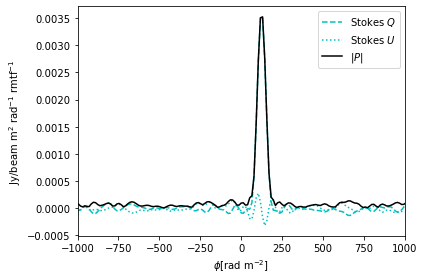

In [58]:
plt.plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(conv_model), 'k-', label=r"$|P|$")
plt.xlim([-1000,1000])
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig("restored.png", dpi=100)

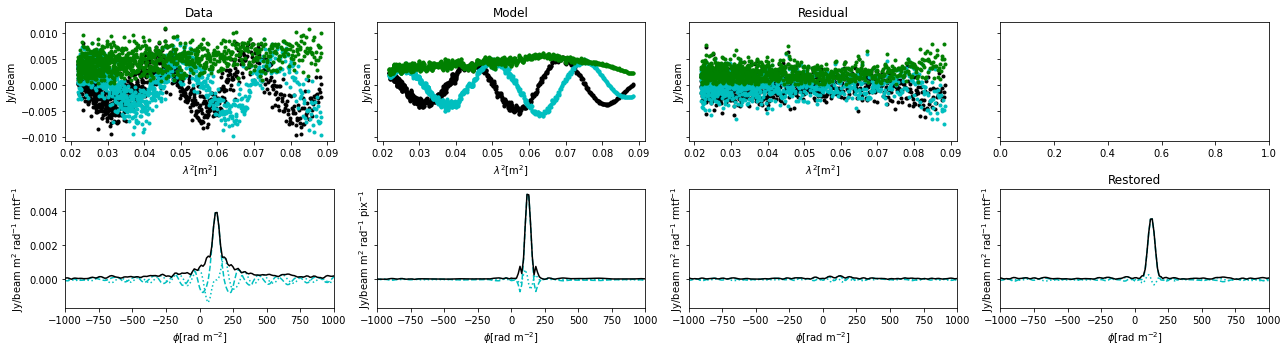

In [59]:
fig, ax = plt.subplots(nrows=2, ncols=4, sharey='row', figsize=(18, 5))

# Data
ax[0,0].plot(measurements.lambda2, measurements.data.real, 'k.', label=r"Stokes $Q$")
ax[0,0].plot(measurements.lambda2, measurements.data.imag, 'c.', label=r"Stokes $U$")
ax[0,0].plot(measurements.lambda2, np.abs(measurements.data), 'g.', label=r"$|P|$")
ax[0,0].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0,0].set_ylabel(r'Jy/beam')
ax[0,0].title.set_text("Data")

ax[1,0].plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
ax[1,0].plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
ax[1,0].plot(parameter.phi, np.abs(F_dirty), 'k-', label=r"|P|")
ax[1,0].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1,0].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1,0].set_xlim([-1000,1000])

# Model
ax[0,1].plot(measurements.lambda2, measurements.model_data.real, 'k.', label=r"Stokes $Q$")
ax[0,1].plot(measurements.lambda2, measurements.model_data.imag, 'c.', label=r"Stokes $U$")
ax[0,1].plot(measurements.lambda2, np.abs(measurements.model_data), 'g.', label=r"$|P|$")
ax[0,1].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0,1].set_ylabel(r'Jy/beam')
ax[0,1].title.set_text("Model")

ax[1,1].plot(parameter.phi, X.data.real, 'c--', label=r"Stokes $Q$")
ax[1,1].plot(parameter.phi, X.data.imag, 'c:', label=r"Stokes $U$")
ax[1,1].plot(parameter.phi, np.abs(X.data), 'k-', label=r"$|P|$")
ax[1,1].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1,1].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
ax[1,1].set_xlim([-1000,1000])

# Residual

# Model
ax[0,2].plot(measurements.lambda2, measurements.residual.real, 'k.', label=r"Stokes $Q$")
ax[0,2].plot(measurements.lambda2, measurements.residual.imag, 'c.', label=r"Stokes $U$")
ax[0,2].plot(measurements.lambda2, np.abs(measurements.residual), 'g.', label=r"$|P|$")
ax[0,2].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0,2].set_ylabel(r'Jy/beam')
ax[0,2].title.set_text("Residual")

ax[1,2].plot(parameter.phi, F_residual.real, 'c--', label=r"Stokes $Q$")
ax[1,2].plot(parameter.phi, F_residual.imag, 'c:', label=r"Stokes $U$")
ax[1,2].plot(parameter.phi, np.abs(F_residual), 'k-', label=r"$|P|$")
ax[1,2].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1,2].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1,2].set_xlim([-1000,1000])


ax[1,3].plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
ax[1,3].plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
ax[1,3].plot(parameter.phi, np.abs(conv_model), 'k-', label=r"$|P|$")
ax[1,3].set_xlim([-1000,1000])
ax[1,3].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1,3].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1,3].title.set_text("Restored")
fig.tight_layout()